# Librerias

In [1]:
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt

# Explicación del modelo

En este caso se empleó un enfoque tight-binding basado en la formulación LCAO simplificada propuesta en *Simplified LCAO Method for the Periodic Potential Problem* (https://doi.org/10.1103/PhysRev.94.1498), el cual es equivalente al esquema de Slater–Koster.

Para los átomos de silicio se consideraron los orbitales $p_x$, $p_y$ y $p_z$, mientras que para el hidrógeno se incluyó únicamente el orbital $s$. El objetivo del método es cuantificar la contribución de los enlaces de tipo $\sigma$ y $\pi$ al hamiltoniano tight-binding mediante integrales de solapamiento entre orbitales atómicos.

La estructura del modelo depende únicamente:

- del vector que conecta los dos sitios $R_{ij}$.
- de su dirección unitaria $\hat{r}_{ij}$, osea de sus cosenos directores.
- del factor de fase de Bloch $\exp(i{K\cdot R})$.

De este modo, la matriz hamiltoniana puede construirse de forma tabulada a partir de los distintos tipos de enlace.

Para enlaces $p$-$p$, se obtienen términos como:

$E_{x, x} = l^2(p p \sigma) + (1 - l^2)(p p \pi)$,

$E_{x, y} = lm(p p \sigma) - lm(p p \pi)$,

$E_{x, z} = ln(p p \sigma) - ln(p p \pi)$.

Mientras que para enlaces $p$-$s$:

$E_{s, x} = l(s p \rho)$,

donde $l$, $m$ y $n$ son los respectivos valores de los cosenos directores y $(p p \sigma)$, $(p p \pi)$ y $(s p \rho)$ son constantes segun el del enlace.
Estos ultimos parametros disminuyen a mayor distancia debido a que el solapamiento entre orbitales es mayor en los primeros vecinos, y va dismininuyendo gradualmente a mayores ordenes de vecindad.

En el caso de los vecinos tomados, fueron los mismos que para fonones.

# Definicion de lattice y varios

In [2]:
# Definicion de lattice y bases fraccionales para hacer producto matricial y obtener coordenadas cartesianas
# (en unidades Å)
a = 3.8901956081
c = 23.7135486603
gamma = np.radians(120)
# Constantes de fuerza (en unidades eV/Å²)
force_constants = {
    "Si-Si": 5,
    "Si-H": 22,
    "2Si-H": 11
}

lattice = np.array([
    [ a, 0.0,  0.0],
    [ a * np.cos(gamma), a * np.sin(gamma) , 0.0],
    [ 0.0, 0.0,  c]
], dtype=float)

base_Si_frac = np.array([
    [2/3, 1/3, 16/33],
    [1/3, 2/3, 17/33]
], dtype=float)

base_H_frac = np.array([
    [2/3, 1/3, 0.4215227810],
    [1/3, 2/3, 0.5784772190]
], dtype=float)


mass = {
    "Si": 28.086,
    "H": 1.008
}

cell = np.concatenate([
    base_Si_frac,
    base_H_frac
]) @ lattice

# Definicion del orden de los atomos en la celda para asignar valores ij
order_i = ["Si", "Si", "H", "H"]
atom_n = len(order_i)
masses_i = np.array([mass[atom] for atom in order_i], dtype=float)
masses_ij = np.sqrt(np.tensordot(masses_i, masses_i, axes=0))
print(masses_ij)

[[28.086      28.086       5.32077889  5.32077889]
 [28.086      28.086       5.32077889  5.32077889]
 [ 5.32077889  5.32077889  1.008       1.008     ]
 [ 5.32077889  5.32077889  1.008       1.008     ]]


# Calculo de vectores $\hat{e}$

In [3]:
# Hallar los vectores e interactuantes y definir las constantes de fuerza
order_pairs = [
    ["Si-Si", "Si-Si", "Si-Si", "Si-H", "2Si-H", "2Si-H", "2Si-H"],
    ["Si-Si", "Si-Si", "Si-Si", "Si-H", "2Si-H", "2Si-H", "2Si-H"],
    ["Si-H", "2Si-H", "2Si-H", "2Si-H", 0, 0, 0],
    ["Si-H", "2Si-H", "2Si-H", "2Si-H", 0, 0, 0]
]

nested_force_cts = [
    [force_constants[atom_pair] if atom_pair != 0 else 0 for atom_pair in sublist]
    for sublist in order_pairs
]

# Convertir a un array de NumPy. Usar dtype=object permite sub-arrays de diferente longitud.
force_cts = np.array(nested_force_cts, dtype=float)

print(force_cts)

# vector final menos inicial para cada par de atomos interactuantes
R_01 = cell[1] - cell[0]
R_02 = cell[2] - cell[0]
R_03 = cell[3] - cell[0]
R_12 = cell[2] - cell[1]
R_13 = cell[3] - cell[1]

# Crear arrays para los vectores e, sus normales y los indices j
e = np.zeros((4, 7, 3), dtype=float)
e_norm = np.zeros((4, 7, 3), dtype=float)
e_jindex = np.zeros((4, 7), dtype=int)

e[0] = np.vstack([
    R_01 + lattice[0],
    R_01 - lattice[1],
    R_01,
    R_02,
    R_03 + lattice[0],
    R_03 - lattice[1],
    R_03
])

# Indices de los atomos con los que interactua el atomo 0 (Si)
e_jindex[0] = np.array([1, 1, 1, 2, 3, 3, 3])

# Normalizar cada vector fila
e_norm[0] = e[0] / np.linalg.norm(e[0], axis=1, keepdims=True)

# Repetir para el atomo 2 (Si)
e[1] = np.vstack([
    -R_01 + lattice[1],
    -R_01 - lattice[0],
    -R_01,
    R_13,
    R_12 + lattice[1],
    R_12 - lattice[0],
    R_12
])

e_jindex[1] = np.array([0, 0, 0, 3, 2, 2, 2])

# Normalizar cada vector fila
e_norm[1] = e[1] / np.linalg.norm(e[1], axis=1, keepdims=True)

e[2,0:4] = np.vstack([
    -R_02,
    -R_12 + lattice[0],
    -R_12 - lattice[1],
    -R_12
])

# Normalizar cada vector fila
e_norm[2,0:4] = e[2,0:4] / np.linalg.norm(e[2,0:4], axis=1, keepdims=True)

e_jindex[2,0:4] = np.array([0, 1, 1, 1])

e[3,0:4] = np.vstack([
    -R_13,
    -R_03 + lattice[1],
    -R_03 - lattice[0],
    -R_03
])

# Normalizar cada vector fila
e_norm[3,0:4] = e[3,0:4] / np.linalg.norm(e[3,0:4], axis=1, keepdims=True)

e_jindex[3,0:4] = np.array([1, 0, 0, 0])

[[ 5.  5.  5. 22. 11. 11. 11.]
 [ 5.  5.  5. 22. 11. 11. 11.]
 [22. 11. 11. 11.  0.  0.  0.]
 [22. 11. 11. 11.  0.  0.  0.]]


# Parametrizacion por el camino de alta simetria
Γ—M—K—Γ—A—L—H—L—M—K—Γ

In [4]:
# Definición de puntos de alta simetría (Kx, Ky, Kz)
# Puntos de alta simetria tomados de: https://seekpath.materialscloud.io/compute/process_structure/

G  = np.array([0.0,         0.0,         0.0        ])   # Gamma
M  = np.array([0.8075667576,0.4662488849,0.0        ])
K  = np.array([0.5383778384,0.9324977698,0.0        ])
A  = np.array([0.0,         0.0,         0.1324809162])
L  = np.array([0.8075667576,0.4662488849,0.1324809162])
H  = np.array([0.5383778384,0.9324977698,0.1324809162])
H2 = np.array([0.5383778384,0.9324977698,-0.1324809162])   # No usado, pero definido

# Camino de alta simetría que se va a recorrer
k_points = [G, M, K, G, A, L, H, L, M, K, G]

# Parametrización del camino
def parametrization_vec(k_points, n_points):
    path = []
    for i in range(len(k_points) - 1):
        start = k_points[i]
        end    = k_points[i + 1]
        paso  = np.linspace(start, end, n_points, endpoint=False)
        path.extend(paso)
    path.append(k_points[-1])
    return np.array(path)

n_points_segment = 100
k_path = parametrization_vec(k_points, n_points_segment)

# Bandas electronicas

In [5]:
# Energías de las orbitas electrónicas
insite_energy = {
    "Si_p": 4.096984,
    "H_s": -3.056510
}

# Parametros de Slater-Koster
SK_param = {
    "p-p-sigma": 4.122363,
    "p-p-pi": -1.522175,
    "s-p-sigma": 3.776178,
    "s-p-sigma-2": 3.776178/2 # Valor para segundo vecino de s-p-sigma, va divido entre 2, podria ser otro valor
}

# Calculo y solución del Hamiltoniano $H(K)$

In [6]:
orbital_num = np.array([3, 3, 1, 1], dtype=int)  # Numero de orbitales por atomo en la celda

n_k = len(k_path)
H = np.zeros((n_k, np.sum(orbital_num), np.sum(orbital_num)), dtype=complex)

# Calcular fases para cada vector k y vector e
phase = np.exp(1j * np.tensordot(k_path, e, axes=([1], [2])))

# Primero la parte no diagonal para luego sumar la transpuesta conjugada y al final del todo sumar las energias in-site

# Elementos Si1-Si2 (Atomos 0 - 1)
H_part = np.zeros((n_k,3,3), dtype=complex)
H_part[:,0,1] = np.sum(e_norm[0,0:3,0] * e_norm[0,0:3,1] * (SK_param["p-p-sigma"] - SK_param["p-p-pi"]) * phase[:,0,0:3], axis=1)
H_part[:,0,2] = np.sum(e_norm[0,0:3,0] * e_norm[0,0:3,2] * (SK_param["p-p-sigma"] - SK_param["p-p-pi"]) * phase[:,0,0:3], axis=1)
H_part[:,1,2] = np.sum(e_norm[0,0:3,1] * e_norm[0,0:3,2] * (SK_param["p-p-sigma"] - SK_param["p-p-pi"]) * phase[:,0,0:3], axis=1)
H_part = H_part + np.conjugate(np.swapaxes(H_part, 1, 2))
H_part[:,0,0] = np.sum((e_norm[0,0:3,0]**2 * SK_param["p-p-sigma"] + (1 - e_norm[0,0:3,0]**2) * SK_param["p-p-pi"]) * phase[:,0,0:3], axis=1)
H_part[:,1,1] = np.sum((e_norm[0,0:3,1]**2 * SK_param["p-p-sigma"] + (1 - e_norm[0,0:3,1]**2) * SK_param["p-p-pi"]) * phase[:,0,0:3], axis=1)
H_part[:,2,2] = np.sum((e_norm[0,0:3,2]**2 * SK_param["p-p-sigma"] + (1 - e_norm[0,0:3,2]**2) * SK_param["p-p-pi"]) * phase[:,0,0:3], axis=1)
H[:, 0:3, 3:6] = H_part

# Elementos Si1-H1 (Atomos 0 - 2) Aquí son cero 2 pero igual lo coloco porque quiero ver si en un futuro puedo hacerlo mas compacto como fonones
H_part = np.zeros((n_k,3), dtype=complex)
H_part[:,0] = e_norm[0,3,0] * SK_param["s-p-sigma"] * phase[:,0,3]
H_part[:,1] = e_norm[0,3,1] * SK_param["s-p-sigma"] * phase[:,0,3]
H_part[:,2] = e_norm[0,3,2] * SK_param["s-p-sigma"] * phase[:,0,3]
H[:, 0:3, 6] = H_part

# Elementos Si1-H2 (Atomos 0 - 3)
H_part = np.zeros((n_k,3), dtype=complex)
H_part[:,0] = np.sum(e_norm[0,4:7,0] * SK_param["s-p-sigma-2"] * phase[:,0,4:7], axis=1)
H_part[:,1] = np.sum(e_norm[0,4:7,1] * SK_param["s-p-sigma-2"] * phase[:,0,4:7], axis=1)
H_part[:,2] = np.sum(e_norm[0,4:7,2] * SK_param["s-p-sigma-2"] * phase[:,0,4:7], axis=1)
H[:, 0:3, 7] = H_part

# Elementos Si2-H1 (Atomos 1 - 2)
H_part = np.zeros((n_k,3), dtype=complex)
H_part[:,0] = np.sum(e_norm[1,4:7,0] * SK_param["s-p-sigma-2"] * phase[:,1,4:7], axis=1)
H_part[:,1] = np.sum(e_norm[1,4:7,1] * SK_param["s-p-sigma-2"] * phase[:,1,4:7], axis=1)
H_part[:,2] = np.sum(e_norm[1,4:7,2] * SK_param["s-p-sigma-2"] * phase[:,1,4:7], axis=1)
H[:, 3:6, 6] = H_part

# Elementos Si2-H2 (Atomos 1 - 3) Aquí son cero 2 pero igual lo coloco porque quiero ver si en un futuro puedo hacerlo mas compacto como fonones
H_part = np.zeros((n_k,3), dtype=complex)
H_part[:,0] = e_norm[1,3,0] * SK_param["s-p-sigma"] * phase[:,1,3]
H_part[:,1] = e_norm[1,3,1] * SK_param["s-p-sigma"] * phase[:,1,3]
H_part[:,2] = e_norm[1,3,2] * SK_param["s-p-sigma"] * phase[:,1,3]
H[:, 3:6, 7] = H_part

# Elementos H1-H2 (Atomos 2 - 3) No se considera interaccion directa

# Sumar la transpuesta conjugada
H = H + np.conjugate(np.swapaxes(H, 1, 2))

# Sumar las energias in-site
H[:, 0:3, 0:3] += insite_energy["Si_p"] * np.identity(3)
H[:, 3:6, 3:6] += insite_energy["Si_p"] * np.identity(3)
H[:, 6:8, 6:8] += insite_energy["H_s"] * np.identity(2)

# Para tener en cuenta spin se hace producto tensorial con matriz identidad 2x2, esto debido a que no hay spin-orbit coupling
H = np.kron(H, np.identity(2))

energias = np.linalg.eigvalsh(H)
energias.sort(axis=1)

# Grafica de bandas

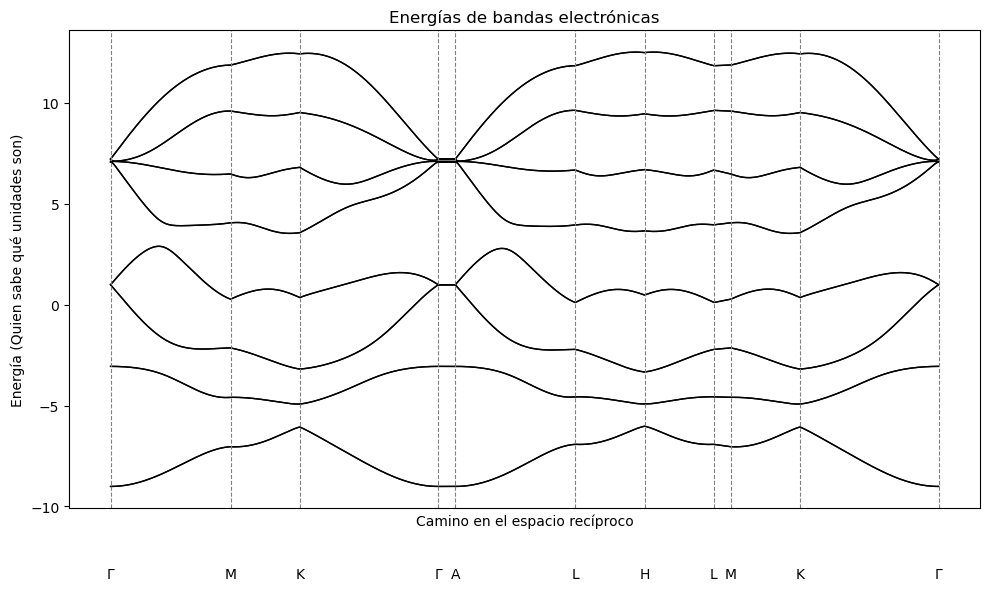

In [7]:
# Cálculo de la norma de k para graficar en función de la distancia en el espacio recíproco
dK = np.linalg.norm( np.diff(k_path, axis=0), axis=1 )
K_norm = np.concatenate(([0], np.cumsum(dK)))

# La misma gráfica de antes pero para las bandas electrónicas
labels = ["Γ","M","K","Γ","A","L","H","L","M","K","Γ"]
plt.figure(figsize=(10,6))
for modo in range(energias.shape[1]):
    plt.plot(K_norm, energias[:, modo], 'k-', linewidth=1)


for i in range(len(labels)):
    plt.axvline(K_norm[n_points_segment * i], color='gray', linestyle='--', linewidth=0.8)
    plt.text(K_norm[n_points_segment * i], -13.0, labels[i], ha='center', va='top')
# plt.ylim( 2.8, 3.0)
plt.title("Energías de bandas electrónicas")
plt.ylabel("Energía (Quien sabe qué unidades son)")
plt.xlabel("Camino en el espacio recíproco")
plt.xticks([])
plt.tight_layout()
plt.show()